# MCI customer churn prediction


## Loding Libraries 

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt

## Data prepration

In [31]:
ls

160.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Customer_Churn.csv*  mci_churn.ipynb*


In [32]:
data = 'Customer_Churn.csv'

In [33]:
df = pd.read_csv(data)

## EDA & Setting up validation framework

### data exploration

In [34]:
df.head().T

,0,1,2,3,4
Call Failure,8.00,0.000,10.00,10.00,3.000
Complains,0.00,0.000,0.00,0.00,0.000
Subscription Length,38.00,39.000,37.00,38.00,38.000
Charge Amount,0.00,0.000,0.00,0.00,0.000
Seconds of Use,4370.00,318.000,2453.00,4198.00,2393.000
Frequency of use,71.00,5.000,60.00,66.00,58.000
Frequency of SMS,5.00,7.000,359.00,1.00,2.000
Distinct Called Numbers,17.00,4.000,24.00,35.00,33.000
Age Group,3.00,2.000,3.00,1.00,1.000
Tariff Plan,1.00,1.000,1.00,1.00,1.000


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [36]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [37]:
df.churn.unique()

array([0, 1])

In [38]:
df.isnull().sum()

call__failure              0
complains                  0
subscription__length       0
charge__amount             0
seconds_of_use             0
frequency_of_use           0
frequency_of_sms           0
distinct_called_numbers    0
age_group                  0
tariff_plan                0
status                     0
age                        0
customer_value             0
churn                      0
dtype: int64

In [39]:
any(df.dtypes == 'object')

False

### Making Train Test Validation sets

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
df_full_train , df_test = train_test_split(df , test_size=.2 , random_state=42)

In [42]:
df_train , df_val = train_test_split(df_full_train , test_size=.25 , random_state=42)

In [43]:
len(df_train), len(df_test) , len(df_val)

(1890, 630, 630)

In [44]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [45]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

### feature importance 

#### global churn balance 

In [46]:
# we can use mean() to calculate rate because we just have a 'uniform distribution'.

global_churn_rate = df_full_train.churn.mean()
round(float(global_churn_rate), 2)

0.15

In [47]:
df_full_train.churn.value_counts(), df_full_train.churn.value_counts(normalize=True)

(churn
 0    2135
 1     385
 Name: count, dtype: int64,
 churn
 0    0.847222
 1    0.152778
 Name: proportion, dtype: float64)

In [48]:
# we see that features age and age_group are the same 
df.age_group.unique() , df.age.unique(), df[df.age_group == 1].age.unique()

(array([3, 2, 1, 4, 5]), array([30, 25, 15, 45, 55]), array([15]))

#### churn rate in age_group feature

In [49]:
for i in sorted(df.age_group.unique()) :
    print( round((df.age_group == i ).mean(), 2), '   ', end='' )

0.04    0.33    0.45    0.13    0.05    

#### unique number of each feature

In [50]:
for col in df.columns:
    print('{}: {}  {}'.format(col , df[col].nunique(), '   '), end='')

call__failure: 37     complains: 2     subscription__length: 45     charge__amount: 11     seconds_of_use: 1756     frequency_of_use: 242     frequency_of_sms: 405     distinct_called_numbers: 92     age_group: 5     tariff_plan: 2     status: 2     age: 5     customer_value: 2654     churn: 2     

In [51]:
# churn rate in tariff_plan feature
df[df.tariff_plan == 1].churn.value_counts(normalize=True)

churn
0    0.83167
1    0.16833
Name: proportion, dtype: float64

#### features with unique nuber less than 5

In [52]:
categorical = list(df.columns[df.nunique() <= 5])
categorical

['complains', 'age_group', 'tariff_plan', 'status', 'age', 'churn']

In [53]:
df_group = df[categorical] .groupby('age').churn.agg(['mean', 'count'])
df_group['diff'] = df_group['mean'] - global_churn_rate
df_group['risk'] = df_group['mean'] / global_churn_rate
df_group

,mean,count,diff,risk
age,,,,
15,0.000000,123,-0.152778,0.000000
25,0.177435,1037,0.024657,1.161392
30,0.161404,1425,0.008626,1.056459
45,0.200000,395,0.047222,1.309091
55,0.011765,170,-0.141013,0.077005


In [54]:
from IPython.display import display

In [55]:
for c in categorical[:-1]:
    df_group = df[categorical] .groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)

,mean,count,diff,risk
complains,,,,
0,0.101409,2909,-0.051368,0.663771
1,0.829876,241,0.677098,5.431912


,mean,count,diff,risk
age_group,,,,
1,0.000000,123,-0.152778,0.000000
2,0.177435,1037,0.024657,1.161392
3,0.161404,1425,0.008626,1.056459
4,0.200000,395,0.047222,1.309091
5,0.011765,170,-0.141013,0.077005


,mean,count,diff,risk
tariff_plan,,,,
1,0.16833,2905,0.015553,1.101799
2,0.02449,245,-0.128288,0.160297


,mean,count,diff,risk
status,,,,
1,0.052787,2368,-0.099991,0.345516
2,0.473146,782,0.320368,3.096954


,mean,count,diff,risk
age,,,,
15,0.000000,123,-0.152778,0.000000
25,0.177435,1037,0.024657,1.161392
30,0.161404,1425,0.008626,1.056459
45,0.200000,395,0.047222,1.309091
55,0.011765,170,-0.141013,0.077005


#### Mutual information

In [56]:
from sklearn.metrics import mutual_info_score

In [57]:
mutual_info_score(df.churn, df.age)

np.float64(0.014855083333204759)

##### 🥵 complicated mind of **me** versus simple and fluent logic of **@alexeygrigorev**

In [58]:
pd.DataFrame( 
    index= list(df.columns[:-1]) ,
    columns= ['Mutual info'],
    data= [ round(mutual_info_score(df.churn, df[col]), 3) for col in list(df.columns[:-1]) ]
)

/home/udi/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


,Mutual info
call__failure,0.006
complains,0.097
subscription__length,0.031
charge__amount,0.038
seconds_of_use,0.312
frequency_of_use,0.112
frequency_of_sms,0.068
distinct_called_numbers,0.064
age_group,0.015
tariff_plan,0.008


##### simple 😂 with **@alexeygrigorev**

In [59]:
def mutual_info_churn_score(series):
    return mutual_info_score(series , df.churn)
    
df[df.columns[:-1]].apply(mutual_info_churn_score).sort_values(ascending=False)

/home/udi/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


customer_value             0.385433
seconds_of_use             0.312075
frequency_of_use           0.111863
status                     0.107841
complains                  0.096946
frequency_of_sms           0.067977
distinct_called_numbers    0.063743
charge__amount             0.038135
subscription__length       0.031406
age                        0.014855
age_group                  0.014855
tariff_plan                0.007977
call__failure              0.005920
dtype: float64

##### Correlations heatmap

<Axes: >

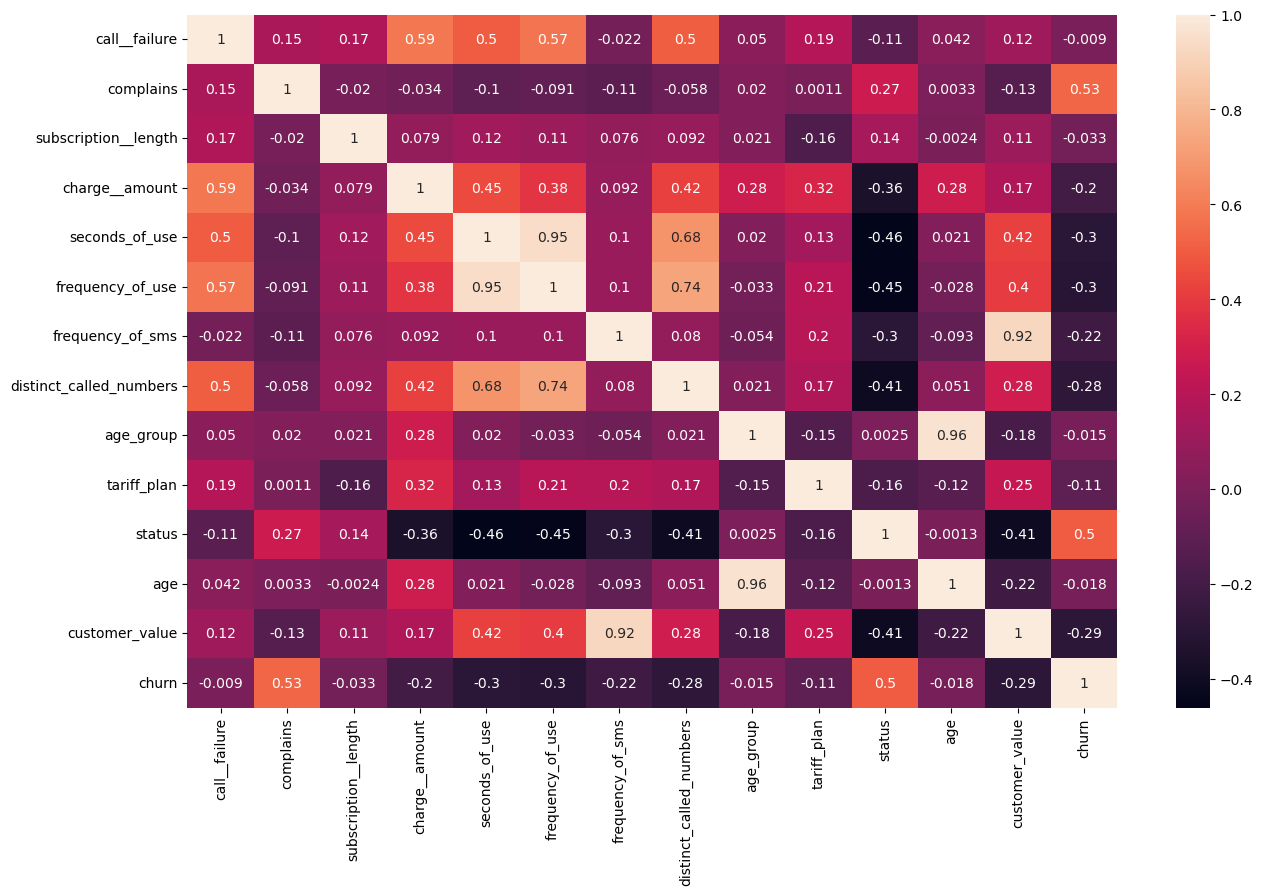

In [73]:
plt.figure(figsize=(15,9))
sns.heatmap(df.corr(), annot=True)

## One-hot encoding 

### sklearn Dictionary Vectorizer

In [84]:
from sklearn.feature_extraction import DictVectorizer

In [90]:
dv = DictVectorizer( sparse=False )

In [97]:
train_dict = df_train.to_dict( orient='records' )

In [126]:
X_train = dv.fit_transform( train_dict )

In [127]:
dv.get_feature_names_out()

array(['age', 'age_group', 'call__failure', 'charge__amount', 'complains',
       'customer_value', 'distinct_called_numbers', 'frequency_of_sms',
       'frequency_of_use', 'seconds_of_use', 'status',
       'subscription__length', 'tariff_plan'], dtype=object)

In [129]:
X_train.shape

(1890, 13)

#### turning numerical variable to categorical

In [160]:
df_full_train[ categorical ] = df_full_train[ categorical ].astype('object')

In [164]:
train_dict = df_full_train.to_dict( orient='records' )

In [165]:
X_train = dv.fit_transform( train_dict )

In [166]:
dv.get_feature_names_out()

array(['age', 'age_group', 'call__failure', 'charge__amount', 'churn',
       'complains', 'customer_value', 'distinct_called_numbers',
       'frequency_of_sms', 'frequency_of_use', 'seconds_of_use', 'status',
       'subscription__length', 'tariff_plan'], dtype=object)